In [20]:
pip install tensorflow numpy pandas scikit-learn matplotlib


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/weatherHistory.csv')

In [22]:
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24508 entries, 0 to 24507
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            24508 non-null  object 
 1   Summary                   24508 non-null  object 
 2   Precip Type               24508 non-null  object 
 3   Temperature (C)           24508 non-null  float64
 4   Apparent Temperature (C)  24508 non-null  float64
 5   Humidity                  24508 non-null  float64
 6   Wind Speed (km/h)         24508 non-null  float64
 7   Wind Bearing (degrees)    24508 non-null  float64
 8   Visibility (km)           24507 non-null  float64
 9   Loud Cover                24507 non-null  float64
 10  Pressure (millibars)      24507 non-null  float64
 11  Daily Summary             24507 non-null  object 
dtypes: float64(8), object(4)
memory usage: 2.2+ MB


(None,
                   Formatted Date        Summary Precip Type  Temperature (C)  \
 0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
 1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
 2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
 3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
 4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   
 
    Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
 0                  7.388889      0.89            14.1197   
 1                  7.227778      0.86            14.2646   
 2                  9.377778      0.89             3.9284   
 3                  5.944444      0.83            14.1036   
 4                  6.977778      0.83            11.0446   
 
    Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
 0                   251.0          15.8263         0.0 

In [23]:
# Convert 'Formatted Date' to datetime format
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])

# Fill missing values in 'Precip Type' with the most frequent category
df['Precip Type'].fillna(df['Precip Type'].mode()[0], inplace=True)

# Drop non-numeric columns not needed for modeling
df = df.drop(columns=['Summary', 'Daily Summary'])

# Sort by datetime
df = df.sort_values(by='Formatted Date').reset_index(drop=True)

# Display dataset info after preprocessing
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24508 entries, 0 to 24507
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            24508 non-null  object 
 1   Precip Type               24508 non-null  object 
 2   Temperature (C)           24508 non-null  float64
 3   Apparent Temperature (C)  24508 non-null  float64
 4   Humidity                  24508 non-null  float64
 5   Wind Speed (km/h)         24508 non-null  float64
 6   Wind Bearing (degrees)    24508 non-null  float64
 7   Visibility (km)           24507 non-null  float64
 8   Loud Cover                24507 non-null  float64
 9   Pressure (millibars)      24507 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.9+ MB


<ipython-input-23-9aa020f060bb>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])
<ipython-input-23-9aa020f060bb>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Precip Type'].fillna(df['Preci

(None,
               Formatted Date Precip Type  Temperature (C)  \
 0  2006-01-01 00:00:00+01:00        rain         0.577778   
 1  2006-01-01 01:00:00+01:00        rain         1.161111   
 2  2006-01-01 02:00:00+01:00        rain         1.666667   
 3  2006-01-01 03:00:00+01:00        rain         1.711111   
 4  2006-01-01 04:00:00+01:00        rain         1.183333   
 
    Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
 0                 -4.050000      0.89            17.1143   
 1                 -3.238889      0.85            16.6152   
 2                 -3.155556      0.82            20.2538   
 3                 -2.194444      0.82            14.4900   
 4                 -2.744444      0.86            13.9426   
 
    Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  
 0                   140.0           9.9820         0.0               1016.66  
 1                   139.0           9.9015         0.0               1016.15  
 2         

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Select target variable and features
target = 'Temperature (C)'
features = ['Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
            'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']

# Normalize features
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

# Prepare sequences for LSTM/GRU
sequence_length = 24  # Using past 24 hours to predict next temperature

def create_sequences(data, target_column, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, target_column])
    return np.array(X), np.array(y)

# Convert dataframe to numpy array
data_array = df_scaled[features + [target]].values

# Create sequences
X, y = create_sequences(data_array, target_column=-1, seq_length=sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 50)         │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,101 (129.30 KB)

 Trainable params: 33,101 (129.30 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 42.8264 - val_loss: nan
Epoch 2/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 1.6272 - val_loss: nan
Epoch 3/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 1.4369 - val_loss: nan
Epoch 4/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 1.3618 - val_loss: nan
Epoch 5/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 1.3664 - val_loss: nan
Epoch 6/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - loss: 1.2127 - val_loss: nan
Epoch 7/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.2142 - val_loss: nan
Epoch 8/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 1.1570 - val_loss: nan
Epoch 9/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 1.1694 - val_loss: nan
Epoch 10/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - loss: 1.1164 - val_loss: nan


In [14]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: nan
Test Loss: nan


In [ ]:
print(f'Test Loss (MSE): {loss}')
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

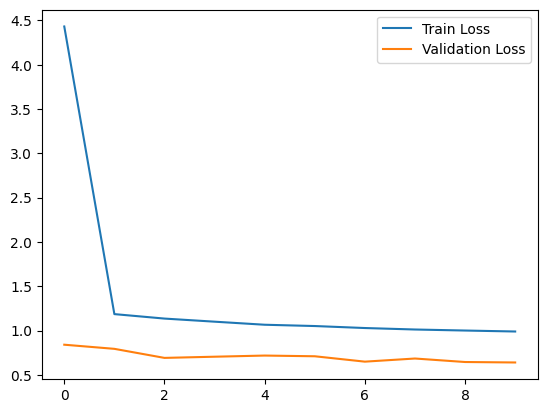

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


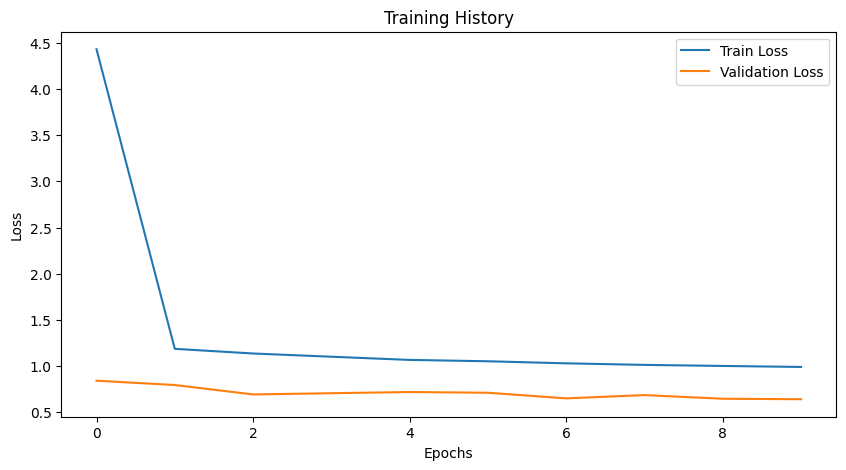

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.show()


In [ ]:
y_pred = model.predict(X_test)

603/603 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


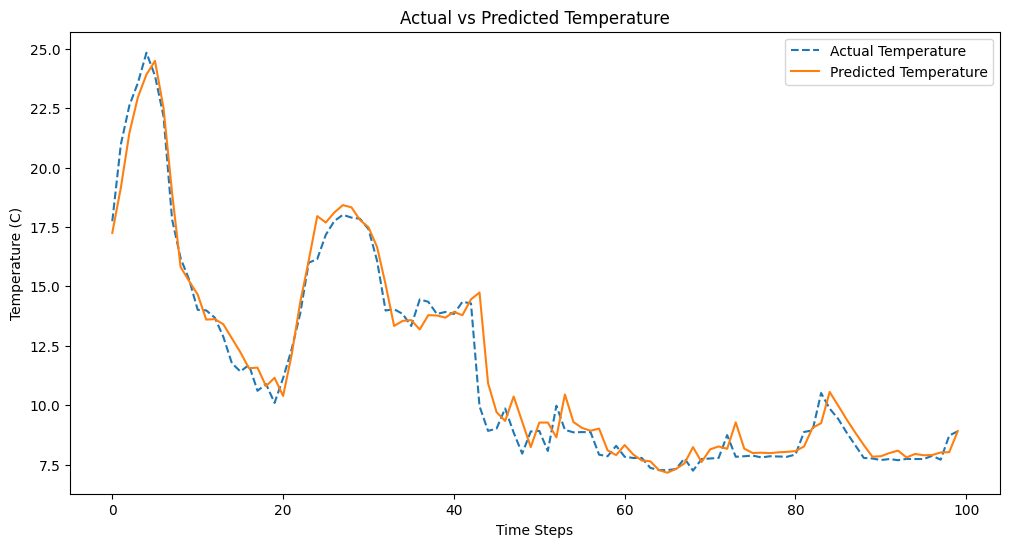

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:100], label='Actual Temperature', linestyle='dashed')
plt.plot(y_pred[:100], label='Predicted Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (C)')
plt.legend()
plt.title('Actual vs Predicted Temperature')
plt.show()

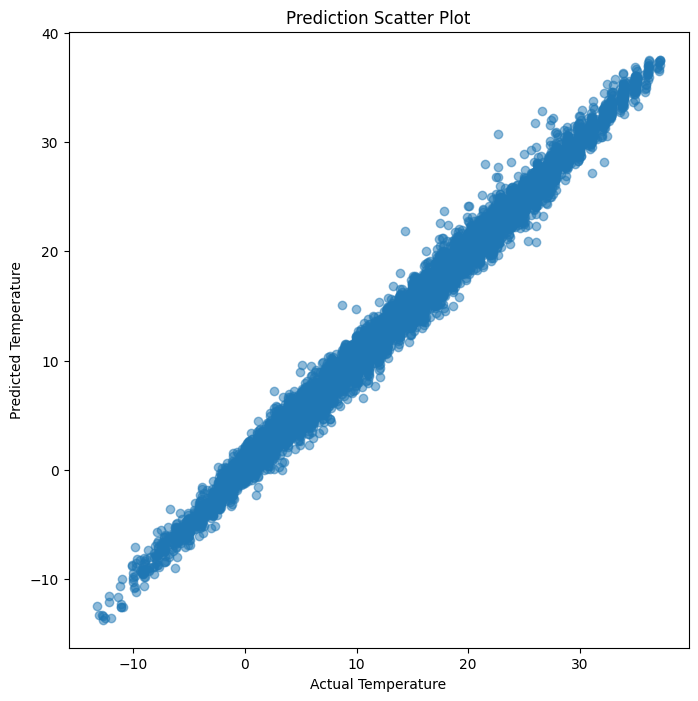

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Prediction Scatter Plot')
plt.show()

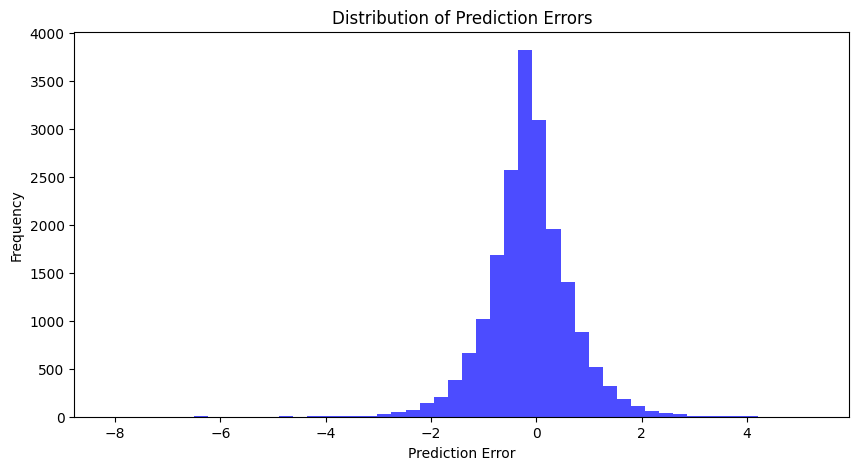

In [ ]:
errors = y_test - y_pred.reshape(-1)
plt.figure(figsize=(10,5))
plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

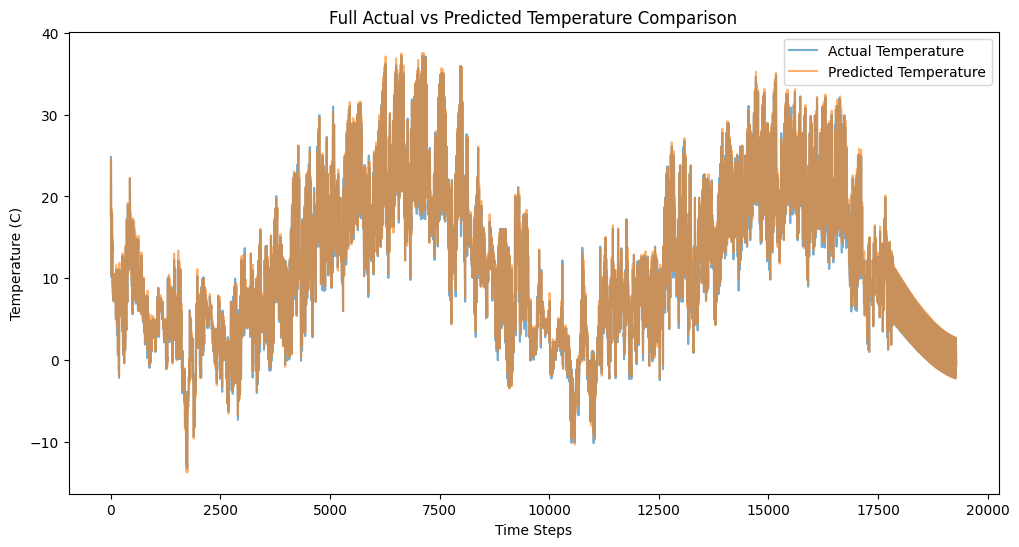

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual Temperature', alpha=0.6)
plt.plot(y_pred, label='Predicted Temperature', alpha=0.6)
plt.xlabel('Time Steps')
plt.ylabel('Temperature (C)')
plt.legend()
plt.title('Full Actual vs Predicted Temperature Comparison')
plt.show()

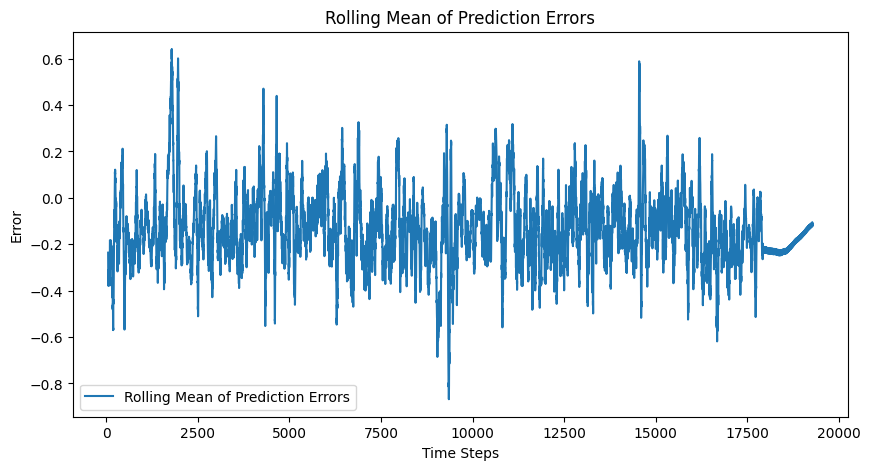

In [ ]:
errors_series = pd.Series(errors)
rolling_errors = errors_series.rolling(window=50).mean()
plt.figure(figsize=(10,5))
plt.plot(rolling_errors, label='Rolling Mean of Prediction Errors')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.legend()
plt.title('Rolling Mean of Prediction Errors')
plt.show()

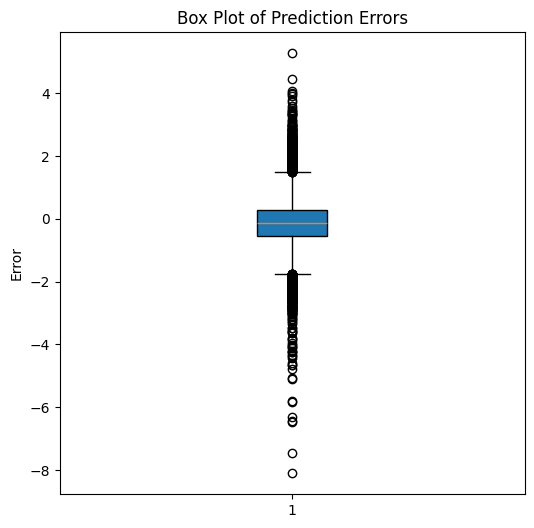

In [ ]:
plt.figure(figsize=(6,6))
plt.boxplot(errors, vert=True, patch_artist=True)
plt.title('Box Plot of Prediction Errors')
plt.ylabel('Error')
plt.show()